In [1]:
import numpy as np
import matplotlib.pyplot as plt
import histlite
from tqdm.notebook import tqdm
import seaborn as sns
from tqdm import tqdm

import sys
sys.path.append('/p/lustre1/yu47/Sterile_Neutrino/sensitivity/')

from neutrino_source import neutrino_source
from detector import detector
from MC_generator import gen_LZ
from MC_generator import MC_generator
from fitter import fitter

A Cr51 hot neutrino source with nominal 100000.0 in xx years with neutrino energies [0.75] and branch ratios [1.0] is created.


# Fitter in sterile neutrino study
One needs to initialize a fitter instance first, where the detector and source instances should be provided as inputs. As during the fitting, one is expected to calculate the prediction spectrum in some functions.

## Oscillation parameters
For oscillation parameter pair ($\Delta m^2, \sin^2(2\theta)$), there two sets of paramters in the fitter -- one for the data and one for the fitting. Especially for the Asimov dataset fitting, as I am calculating the dataset and PDF in real-time, one needs to specify thoese parameters before fitting.

In [2]:
# nEXO exp
source_nEXO = neutrino_source('Cr51', 1e5, [0.75], [1.0])
det_nEXO = detector('nEXO')
det_nEXO.update_geometry(1.183, 1.133)
det_nEXO.position = (0, 0, 0)
dist = 0.1
source_nEXO.position = (0, 0, -det_nEXO.height/2-dist)
det_nEXO.run_time = 100 # days

dm2, sin2theta_square = 0.0, 0.0
gen1 = MC_generator(source_nEXO, det_nEXO, dm2=dm2, sin2theta_square=sin2theta_square, int_type='CC'); 

my_fit = fitter(source_nEXO, det_nEXO)

A Cr51 hot neutrino source with nominal 100000.0 in xx years with neutrino energies [0.75] and branch ratios [1.0] is created.


15.620574426331535
0.625642114228553


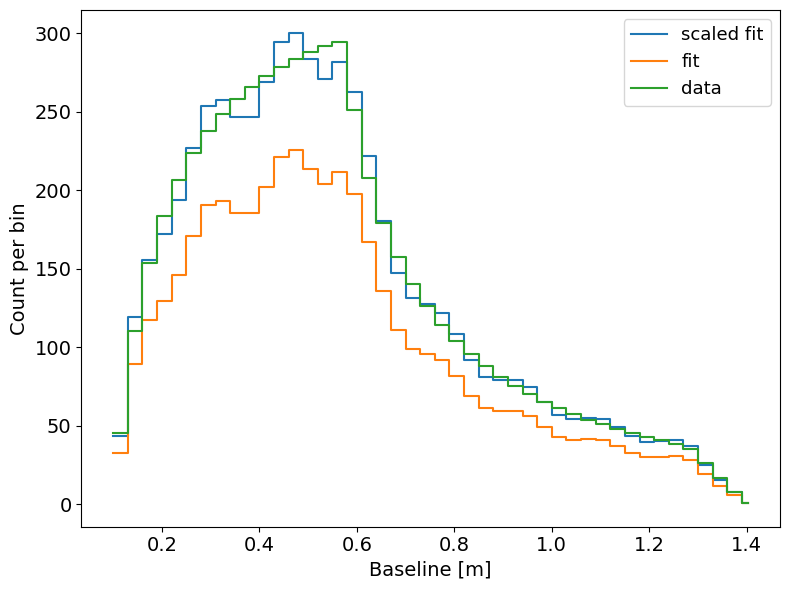

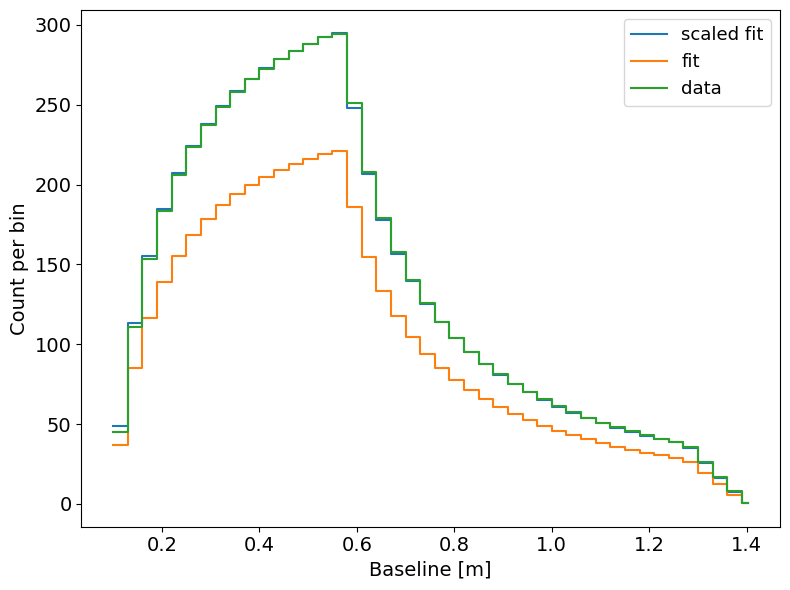

In [3]:
###############################
## A quick look at the asimov calculation methods in fitter class:
###############################

my_fit._set_data_dm2(0.0)
my_fit._set_data_sin2(0.0)

'''
my_fit._set_fit_dm2(29.80)
my_fit._set_fit_sin2(0.6)
_, _, R, dc, _ = my_fit.calculate_shape_only_dchi2_asimov_scanRate(draw=True);
dchi2_0 = np.min(dc)
print(dchi2_0)

my_fit._set_fit_dm2(30.10)
my_fit._set_fit_sin2(0.6)
_, _, R, dc, _ = my_fit.calculate_shape_only_dchi2_asimov_scanRate(draw=True);
dchi2_1 = np.min(dc)
print(dchi2_1)
'''

my_fit._set_fit_dm2(50.40)
my_fit._set_fit_sin2(0.5)
_, _, R, dc, _ = my_fit.calculate_shape_only_dchi2_asimov_scanRate(draw=True);
dchi2_2 = np.min(dc)
print(dchi2_2)

my_fit._set_fit_dm2(61.80)
my_fit._set_fit_sin2(0.5)
_, _, R, dc, _ = my_fit.calculate_shape_only_dchi2_asimov_scanRate(draw=True);
dchi2_3 = np.min(dc)
print(dchi2_3)

#from oscillation import *
#print(oscillation_length(50.80, 0.75))

#coarse_R, coarse_dchi2, fine_R, fine_dchi2, _ = my_fit.calculate_shape_only_dchi2_asimov_scanRate(draw=True)
#minid = np.argmin(coarse_dchi2)
#plt.plot(coarse_R[minid-2:minid+3], coarse_dchi2[minid-2:minid+3], 'o-')
##plt.plot(fine_R, fine_dchi2, 'o-')
##plt.xlabel(r'$R$', fontsize=14)
##plt.ylabel(r'$\Delta\chi^2$', fontsize=14)

## Asimov dataset fitting
There is no fluctuation in Asimov dataset. In the current codes, the asimov dataset and PDFs are calculated when the fitting function is invoked, not pre-generated for now. There are total three methods under studied:

1. Rate-only method: we do not use any spectral informaion, instead, we only use the expected counts to construct the test statistics as $\Delta \chi^2 = \frac{(P-D)^2}{\sigma^2}$ (where $P$ is the predicted signal count, $D$ and $\sigma$ are the measured signal count and corresponding error -- Poisson for now);

2. Shape-only fixed method: we calculate the 

In [4]:
def get_2d_chi2(method:str, dm2_arr:list, sin2_arr:list, data_dm2:float=0.0, data_sin2:float=0.0, ) -> tuple[list, list]:
    '''
    will return two arrays: one is the fitted R, the 2nd is the dchi.
    '''
    my_fit._set_data_dm2(data_dm2)
    my_fit._set_data_sin2(data_sin2)
    Ndm2 = len(dm2_arr)
    Nsin2 = len(sin2_arr)
    R_arr = np.zeros((Ndm2, Nsin2))
    dchi2_arr = np.zeros((Ndm2, Nsin2))
    for i, my_fit_dm2 in tqdm( enumerate(dm2_arr) ):
        for j, my_fit_sin2 in enumerate(sin2_arr):
            my_fit._set_fit_dm2(my_fit_dm2)
            my_fit._set_fit_sin2(my_fit_sin2)
            Rmin = 0.
            if method == 'rate-only':
                dchi2 = my_fit.calculate_rateonly_dchi2_asimov()
            elif method == 'shape-only-fixed':
                dchi2 = my_fit.calculate_shape_only_dchi2_asimov_fixedRate()
            elif method == 'shape-only-scan':
                _, _, fine_R, fine_dchi2 = my_fit.calculate_shape_only_dchi2_asimov_scanRate()
                Rmin = fine_R[np.argmin(fine_dchi2)]
                dchi2 = np.min(fine_dchi2)
            else:
                print(f'There is no such a method {method}')
                return R_arr, dchi2_arr

            R_arr[i, j] = Rmin
            dchi2_arr[i, j] = dchi2

    return R_arr, dchi2_arr


In [5]:
def plot_2d(dm2_arr, sin2_arr, R_arr, dchi2_arr, method='rate-only', plotR=False, contour=False, levels=[]):
    from matplotlib import colors
    fig, ax = plt.subplots(figsize=(8, 6))

    im = ax.pcolormesh(sin2_arr, dm2_arr, dchi2_arr, norm=colors.LogNorm(vmin=np.min(dchi2_arr), vmax=np.max(dchi2_arr)))

    if contour:
        X, Y = np.meshgrid(sin2_arr, dm2_arr)
        if len(levels) == 0:
            levels = [ 4.605, 5.991,  9.210] # 90%, 95%, 99% C.I.
        CS = ax.contour(X, Y, dchi2_arr, levels=levels, colors=['blue', 'red', 'orange', ])
        #ax.clabel(CS, inline=True, fontsize=16)

    ax.loglog()
    cb = plt.colorbar(im, ax=ax)
    ax.set_xlabel(r'$\sin^2(2\theta)$', fontsize=14)
    ax.set_ylabel(r'$\Delta m^2$', fontsize=14)
    ax.tick_params(labelsize=13)
    cb.set_label(r'$\Delta\chi^2$', fontsize=14, rotation=270, labelpad=25)
    cb.ax.tick_params(labelsize=14)
    ax.set_title(f'Asimov dataset: {method}', fontsize=14, pad=15)

    if plotR:
        fig, ax0 = plt.subplots(figsize=(8, 6))
        im = ax0.pcolormesh(sin2_arr, dm2_arr, R_arr[::-1, :], )
        ax0.loglog()
        cb = plt.colorbar(im, ax=ax0)
        ax0.set_xlabel(r'$\sin^2(2\theta)$', fontsize=14)
        ax0.set_ylabel(r'$\Delta m^2$', fontsize=14)
        ax0.tick_params(labelsize=13)
        cb.set_label(r'$R_\mathrm{fit}$', fontsize=14, rotation=270, labelpad=25)
        cb.ax.tick_params(labelsize=14)
        ax0.set_title(f'Asimov dataset: {method}', fontsize=14, pad=15)

    plt.tight_layout()

    if contour:
        x_coords_arr, y_coords_arr = [], []
        for i, collection in enumerate(CS.collections):
            for path in collection.get_paths():
                v = path.vertices
                x_coords = v[:, 0]
                y_coords = v[:, 1]
                
                sorted_indices = np.argsort(y_coords)
                y_coords_sorted = y_coords[sorted_indices]
                x_coords_sorted = x_coords[sorted_indices]
                
                x_coords_arr.append( x_coords_sorted )
                y_coords_arr.append( y_coords_sorted )
    
        return fig, x_coords_arr, y_coords_arr
    return fig

1.1 39.213117823243785
1.1440000000000001 30.637077601947176


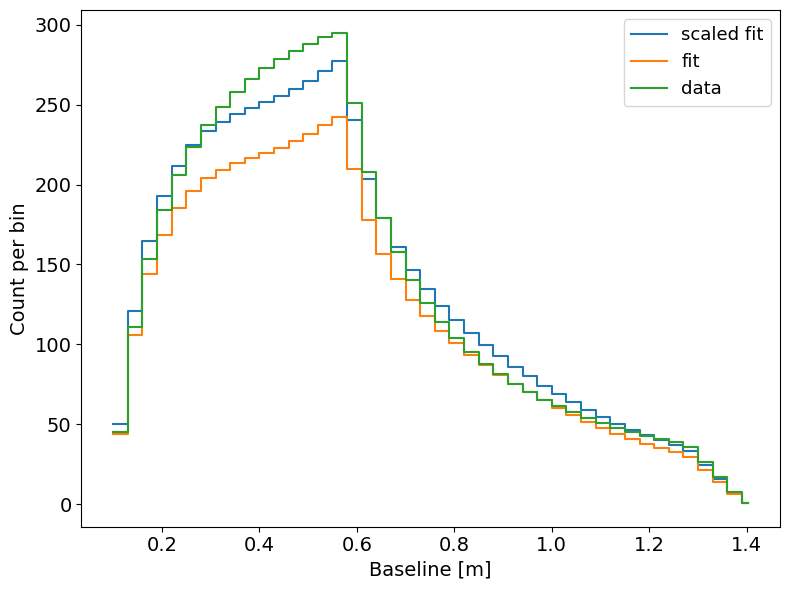

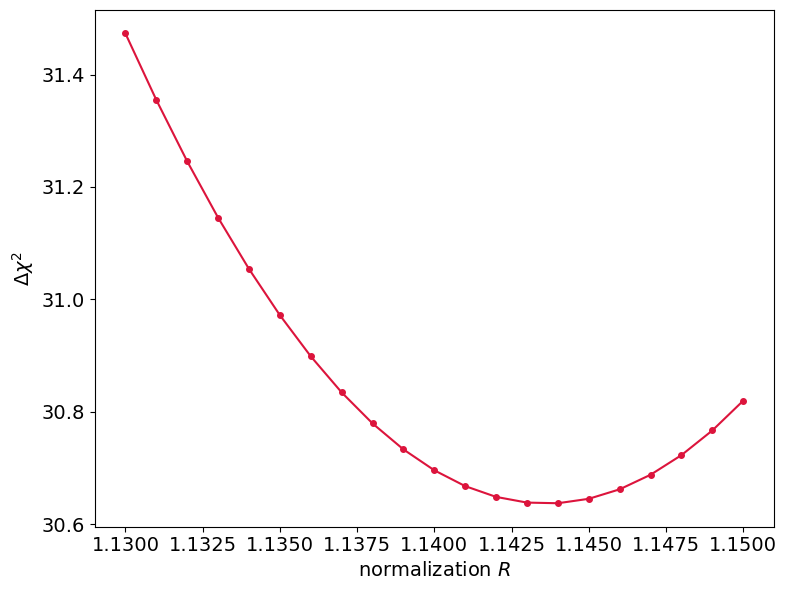

In [10]:
my_fit._set_data_dm2(0.0)
my_fit._set_data_sin2(0.0)
my_fit._set_fit_dm2(2.0)
my_fit._set_fit_sin2(0.2)
x0, y0, x1, y1, fig = my_fit.calculate_shape_only_dchi2_asimov_scanRate(draw=True)
print(x0[np.argmin(y0)], np.min(y0))
print(x1[np.argmin(y1)], np.min(y1))

fig1, ax = plt.subplots(figsize=(8, 6))
#ax.plot(x0, y0, 'o-', ms=4)
ax.plot(x1, y1, 'o-', ms=4, color='crimson')
ax.set_xlabel(r'normalization $R$', fontsize=14)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=14)
ax.tick_params(labelsize=14)
plt.tight_layout()

In [2]:
!pwd

/p/lustre1/yu47/Sterile_Neutrino/sensitivity/notebooks


## Two-dimensional calculation

It seems like the granularity is not fine enough so that the contour plot is not continuous. I submitted multiple jobs to calculate chi2 in smaller grids then.

Here is the function I load the 2D $\Delta \chi^2$ map into the memeory (partly or as a whole) to do more analysis.

In [6]:
import os
import h5py as h5

def load_2d_chi2map_fromSubfiles(method, dm2min, dm2max, sin2min, sin2max, binwidth):
    path = '/p/lustre1/yu47/Sterile_Neutrino/jobs/Fits/'

    Ndm2 = int((dm2max - dm2min) * 100)
    Nsin2 = int((sin2max - sin2min) * 100)

    dm2_arr = np.logspace(dm2min, dm2max, Ndm2)
    sin2_arr = np.logspace(sin2min, sin2max, Nsin2)

    dchi2_arr = np.zeros((Ndm2, Nsin2))

    for i in range(dm2max-dm2min):
        for j in range(sin2max-sin2min):
            filename = f'AsimovFit_{method}_dm2From{dm2min+i}To{dm2min+i+1}_sin2From{sin2min+j}To{sin2min+j+1}_dchi2_binwidth{binwidth:.1f}cm.h5'
            if not os.path.exists(path + filename):
                print(f'{filename} does not exist!')
            print(filename)
            with h5.File(path+filename, 'r') as fin:
                dat = fin['dchi2'][:]

            for x in range(100):
                for y in range(100):
                    row = i * 100 + x
                    col = j * 100 + y
                    dchi2_arr[row, col] = dat[x, y]                   
    return dm2_arr, sin2_arr, dchi2_arr

def load_2d_chi2map(method, dm2min=-2, dm2max=2, sin2min=-3, sin2max=0, binwidth=0.03):
    path = '/p/lustre1/yu47/Sterile_Neutrino/jobs/Fits/'
    filename = f'AsimovFit_{method}_dm2From{dm2min}To{dm2max}_sin2From{sin2min}To{sin2max}_dchi2_binwidth{binwidth*100:.1f}cm.h5'
    
    Ndm2 = int((dm2max - dm2min) * 100)
    Nsin2 = int((sin2max - sin2min) * 100)
    dm2_arr = np.logspace(dm2min, dm2max, Ndm2)
    sin2_arr = np.logspace(sin2min, sin2max, Nsin2)
    
    if not os.path.exists(path+filename):
        print(f'{path+filename} dose not exist !')
        return
    with h5.File(path+filename, 'r') as f:
        dchi2 = f['dchi2'][:]
    return dm2_arr, sin2_arr, dchi2
            
        

In [7]:
dm2min, dm2max, sin2min, sin2max = -2, 2, -3, 0

dm2_rateonly_1, sin2_rateonly_1, dchi2_rateonly_1                   = load_2d_chi2map('rate-only',          dm2min, dm2max, sin2min, sin2max, 0.01)
dm2_shapeonlyfixed_1, sin2_shapeonlyfixed_1, dchi2_shapeonlyfixed_1 = load_2d_chi2map('shape-only-fixed',   dm2min, dm2max, sin2min, sin2max, 0.01)
dm2_shapeonlyscan_1, sin2_shapeonlyscan_1, dchi2_shapeonlyscan_1    = load_2d_chi2map('shape-only-scan',    dm2min, dm2max, sin2min, sin2max, 0.01)
#dm2_shapeonlyfit_1, sin2_shapeonlyfit_1, dchi2_shapeonlyfit_1       = load_2d_chi2map('shape-only-fit',     dm2min, dm2max, sin2min, sin2max, 0.01)

dm2_rateonly_3, sin2_rateonly_3, dchi2_rateonly_3                   = load_2d_chi2map('rate-only',          dm2min, dm2max, sin2min, sin2max, 0.03)
dm2_shapeonlyfixed_3, sin2_shapeonlyfixed_3, dchi2_shapeonlyfixed_3 = load_2d_chi2map('shape-only-fixed',   dm2min, dm2max, sin2min, sin2max, 0.03)
dm2_shapeonlyscan_3, sin2_shapeonlyscan_3, dchi2_shapeonlyscan_3    = load_2d_chi2map('shape-only-scan',    dm2min, dm2max, sin2min, sin2max, 0.03)
dm2_shapeonlyfit_3, sin2_shapeonlyfit_3, dchi2_shapeonlyfit_3       = load_2d_chi2map('shape-only-fit',     dm2min, dm2max, sin2min, sin2max, 0.03)

dm2_rateonly_5, sin2_rateonly_5, dchi2_rateonly_5                   = load_2d_chi2map('rate-only',          dm2min, dm2max, sin2min, sin2max, 0.05)
dm2_shapeonlyfixed_5, sin2_shapeonlyfixed_5, dchi2_shapeonlyfixed_5 = load_2d_chi2map('shape-only-fixed',   dm2min, dm2max, sin2min, sin2max, 0.05)
dm2_shapeonlyscan_5, sin2_shapeonlyscan_5, dchi2_shapeonlyscan_5    = load_2d_chi2map('shape-only-scan',    dm2min, dm2max, sin2min, sin2max, 0.05)
dm2_shapeonlyfit_5, sin2_shapeonlyfit_5, dchi2_shapeonlyfit_5       = load_2d_chi2map('shape-only-fit',     dm2min, dm2max, sin2min, sin2max, 0.05)

/var/tmp/yu47/ipykernel_379203/471668038.py:39: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for i, collection in enumerate(CS.collections):


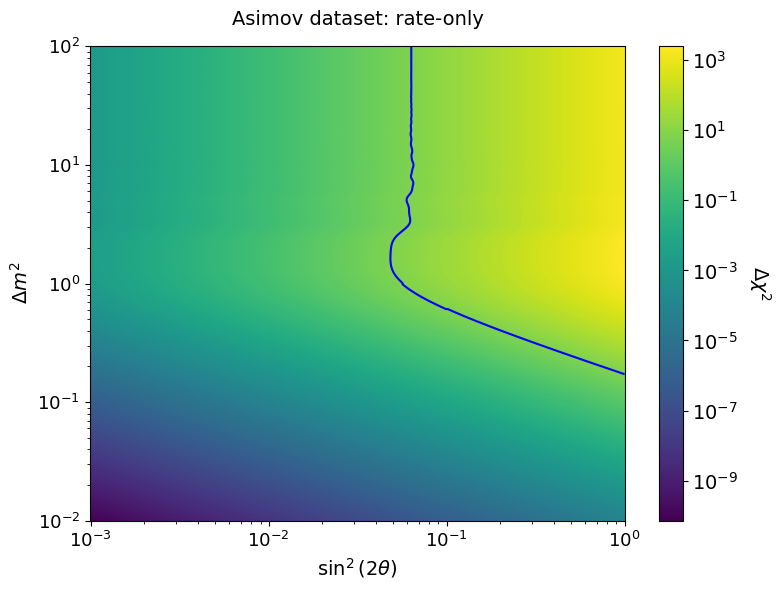

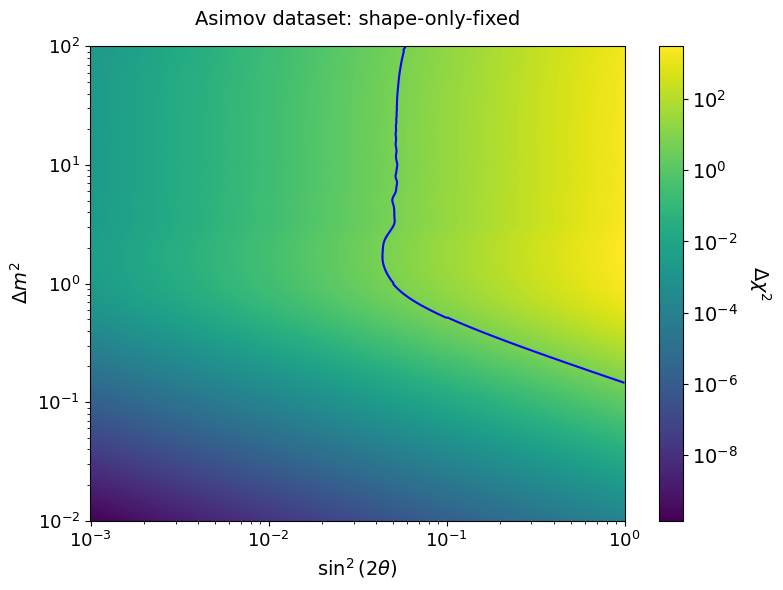

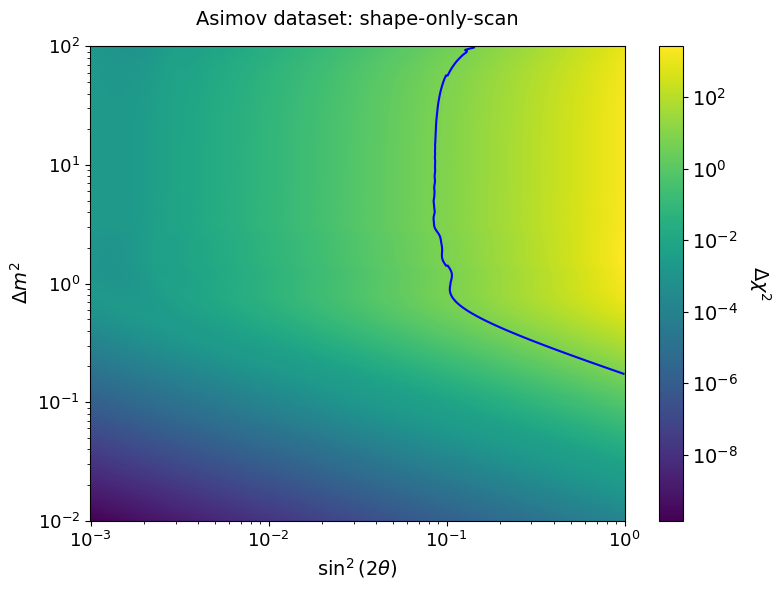

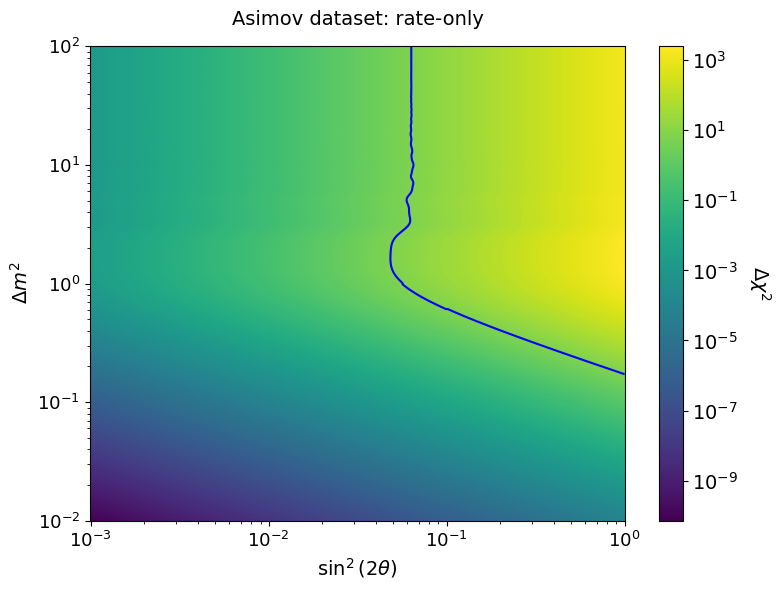

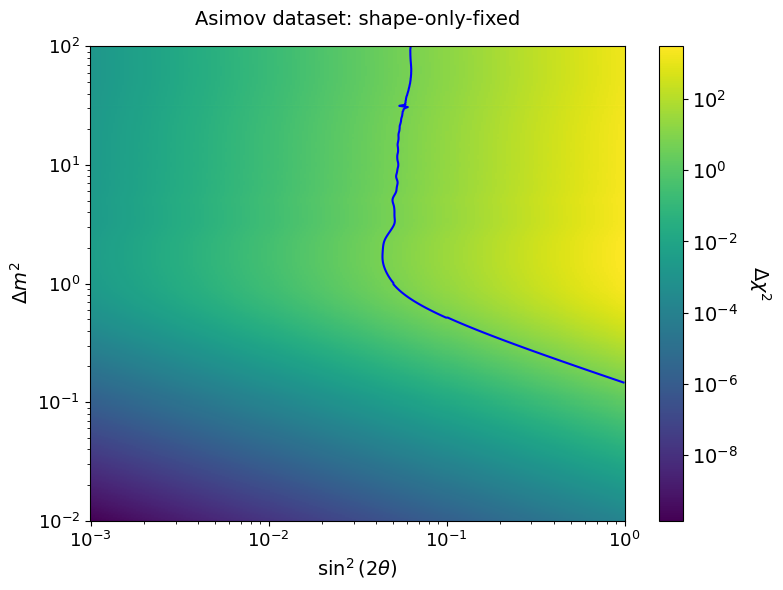

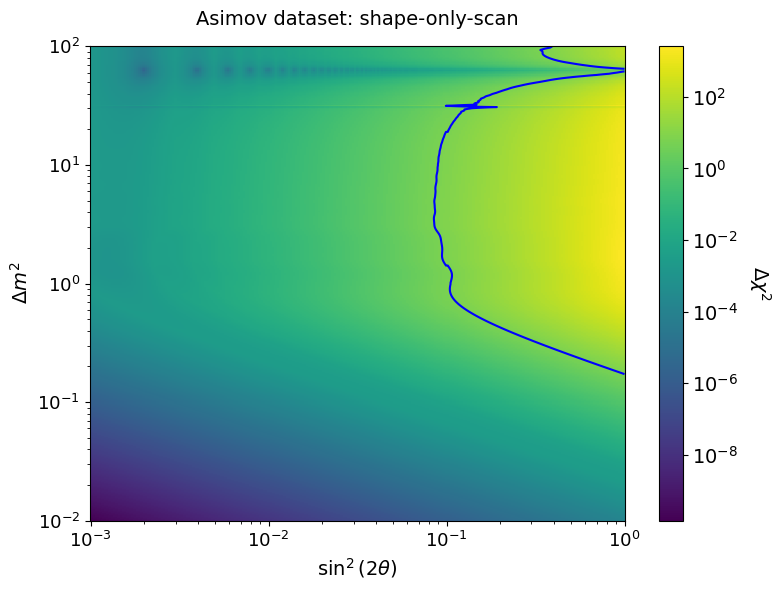

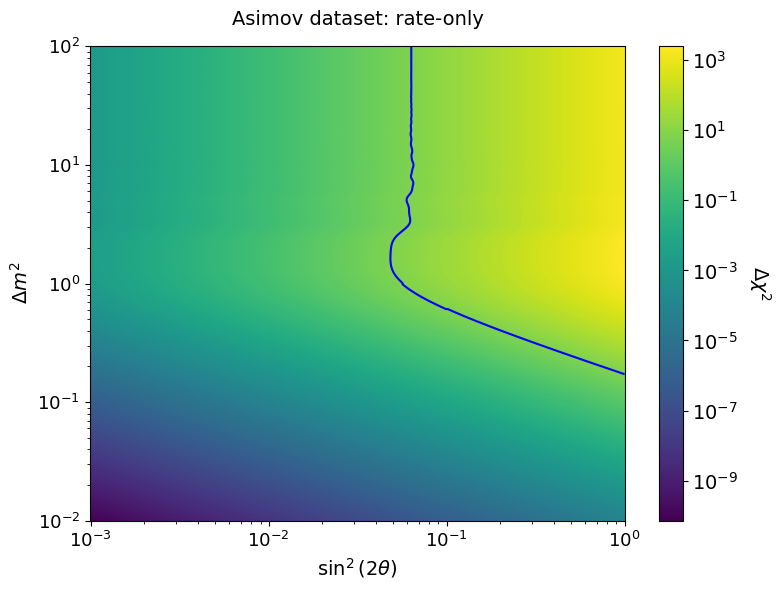

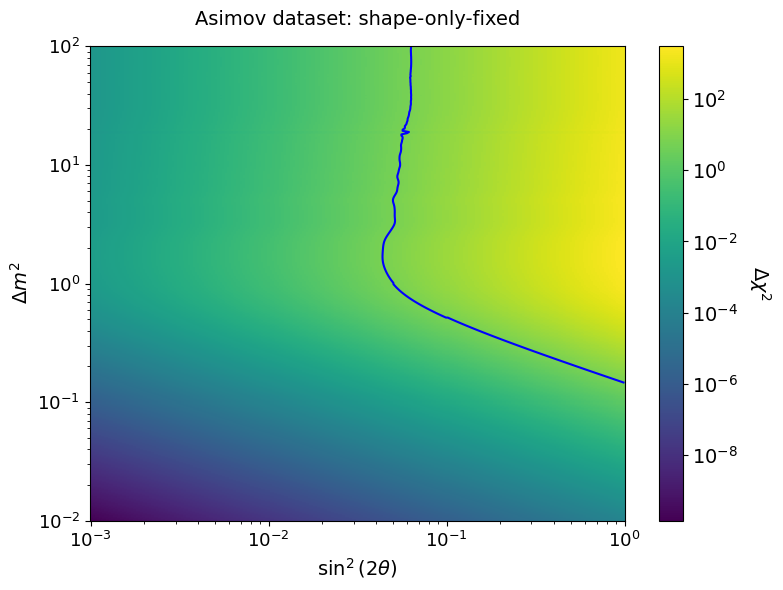

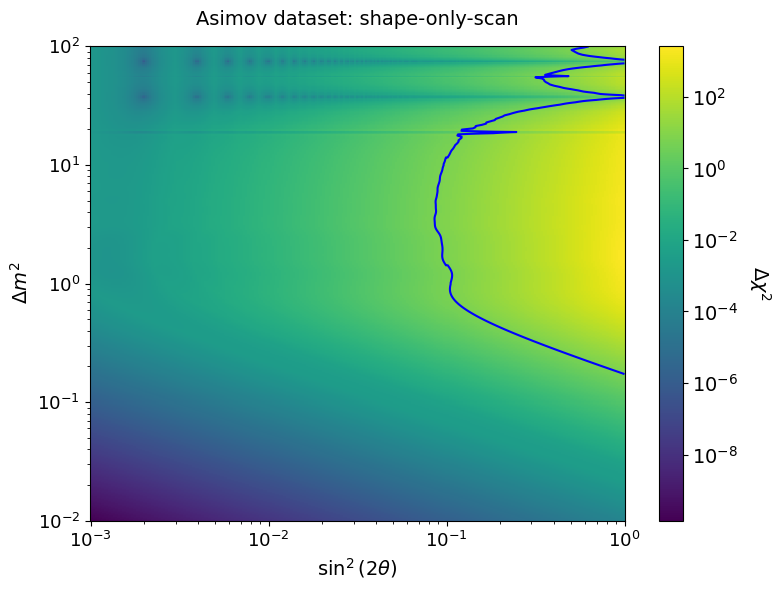

In [8]:
f0_1, x0_1, y0_1 = plot_2d(dm2_rateonly_1,        sin2_rateonly_1,        [], dchi2_rateonly_1[:,:],        method='rate-only',         plotR=False, contour=True, levels=[ 5.991 ]); #f0.savefig('../plots/Asimov_rate-only_binwidth1cm.pdf')
f1_1, x1_1, y1_1 = plot_2d(dm2_shapeonlyfixed_1,  sin2_shapeonlyfixed_1,  [], dchi2_shapeonlyfixed_1[:,:],  method='shape-only-fixed',  plotR=False, contour=True, levels=[ 5.991 ]); #f1.savefig('../plots/Asimov_shape-only-fixed_binwidth1cm.pdf')
f2_1, x2_1, y2_1 = plot_2d(dm2_shapeonlyscan_1,   sin2_shapeonlyscan_1,   [], dchi2_shapeonlyscan_1[:,:],   method='shape-only-scan',   plotR=False, contour=True, levels=[ 5.991 ]); #f2.savefig('../plots/Asimov_shape-only-scan_binwidth1cm.pdf')

f0_3, x0_3, y0_3 = plot_2d(dm2_rateonly_3,        sin2_rateonly_3,        [], dchi2_rateonly_3[:,:],        method='rate-only',         plotR=False, contour=True, levels=[ 5.991 ]); #f0.savefig('../plots/Asimov_rate-only_binwidth1cm.pdf')
f1_3, x1_3, y1_3 = plot_2d(dm2_shapeonlyfixed_3,  sin2_shapeonlyfixed_3,  [], dchi2_shapeonlyfixed_3[:,:],  method='shape-only-fixed',  plotR=False, contour=True, levels=[ 5.991 ]); #f1.savefig('../plots/Asimov_shape-only-fixed_binwidth1cm.pdf')
f2_3, x2_3, y2_3 = plot_2d(dm2_shapeonlyscan_3,   sin2_shapeonlyscan_3,   [], dchi2_shapeonlyscan_3[:,:],   method='shape-only-scan',   plotR=False, contour=True, levels=[ 5.991 ]); #f2.savefig('../plots/Asimov_shape-only-scan_binwidth1cm.pdf')

f0_5, x0_5, y0_5 = plot_2d(dm2_rateonly_5,        sin2_rateonly_5,        [], dchi2_rateonly_5[:,:],        method='rate-only',         plotR=False, contour=True, levels=[ 5.991 ]); #f0.savefig('../plots/Asimov_rate-only_binwidth1cm.pdf')
f1_5, x1_5, y1_5 = plot_2d(dm2_shapeonlyfixed_5,  sin2_shapeonlyfixed_5,  [], dchi2_shapeonlyfixed_5[:,:],  method='shape-only-fixed',  plotR=False, contour=True, levels=[ 5.991 ]); #f1.savefig('../plots/Asimov_shape-only-fixed_binwidth1cm.pdf')
f2_5, x2_5, y2_5 = plot_2d(dm2_shapeonlyscan_5,   sin2_shapeonlyscan_5,   [], dchi2_shapeonlyscan_5[:,:],   method='shape-only-scan',   plotR=False, contour=True, levels=[ 5.991 ]); #f2.savefig('../plots/Asimov_shape-only-scan_binwidth1cm.pdf')
#f3, x3, y3 = plot_2d(dm2_shapeonlyfit_5,    sin2_shapeonlyfit_5,    [], dchi2_shapeonlyfit_5[:,:],    method='shape-only-fit',    plotR=False, contour=True, levels=[ 5.991 ]); f3.savefig('../plots/Asimov_shape-only-fit_binwidth5cm.pdf')

In [9]:
def load_reactor_allowed_regions():
    path = '/p/lustre1/yu47/Sterile_Neutrino/sensitivity/data/'
    filelist = [path+f'reactor_global_allowed_region_{i}.csv' for i in range(4)]
    regions_x, regions_y = [], []
    for filename in filelist:
        if not os.path.exists(filename):
            print(filename)
            continue
        else:
            arr = np.loadtxt(filename)
            xi, yi = arr[:, 0], arr[:, 1]
            regions_x.append(xi)
            regions_y.append(yi)
    return regions_x, regions_y

reactor_x, reactor_y = load_reactor_allowed_regions()

(0.1, 10.0)

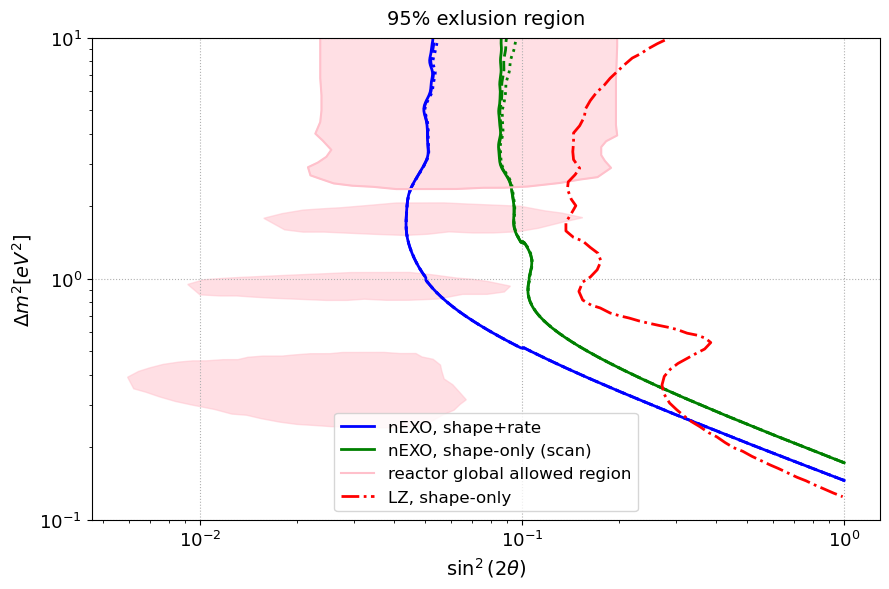

In [14]:
my_fit.other_exp_files = ['/p/lustre1/yu47/Sterile_Neutrino/sensitivity/data/LZ_natural_LXe_shapeonly.csv']
my_fit.load_other_experiments_sensitivity()

fig, ax = plt.subplots(figsize=(9, 6))

#ax.plot(x0_1[0], y0_1[0], '-', color='blue',        linewidth=2, label='nEXO, rate-only')
ax.plot(x1_1[0], y1_1[0], '-', color='blue',  linewidth=2, label='nEXO, shape+rate')
ax.plot(x2_1[0], y2_1[0], '-', color='green', linewidth=2, label='nEXO, shape-only (scan)')

#ax.plot(x0_3[0], y0_3[0], '--', color='blue',       linewidth=2, )
ax.plot(x1_3[0], y1_3[0], '--', color='blue', linewidth=2, )
ax.plot(x2_3[0], y2_3[0], '--', color='green',linewidth=2, )

#ax.plot(x0_5[0], y0_5[0], ':', color='blue',        linewidth=2, )
ax.plot(x1_5[0], y1_5[0], ':', color='blue',  linewidth=2, )
ax.plot(x2_5[0], y2_5[0], ':', color='green', linewidth=2, )

for k, (xs, ys) in enumerate( zip(reactor_x, reactor_y) ):
    if k == 0:
        ax.plot(xs, ys, '-', color='pink', label='reactor global allowed region')
    ax.fill(xs, ys, '-', color='pink', alpha=0.5)


ax.plot(my_fit.other_exp_sens[0][:, 0], my_fit.other_exp_sens[0][:, 1], lw=2, linestyle='-.', color='red', label='LZ, shape-only')
ax.loglog()
ax.set_xlabel(r'$\sin^2(2\theta)$', fontsize=14)
ax.set_ylabel(r"$\Delta m^2 [eV^2]$", fontsize=14)
ax.tick_params(labelsize=13)
#ax.legend(fontsize=12, loc=(0.52, 0.35))
ax.legend(fontsize=12)
ax.grid(linestyle=':')
ax.set_title('95% exlusion region', fontsize=14, pad=10)
plt.tight_layout()  
ax.set_ylim(1e-1, 1e1)
#plt.savefig('../plots/AsimovComparison_binwidth1cm3cm5m.pdf')

### Structures understanding

There are unclear structures on the 2D $\Delta \chi^2$ plots for scanning R calculation. I try to understand it by looking into more deeply here.

In [117]:
method = 'shape-only-scan'
dm2_arr = np.arange(50, 70, 1)
sin2_arr = np.logspace(-2, 0, 20)

R, dchi2 = get_2d_chi2(method, dm2_arr, sin2_arr, data_dm2=0.0, data_sin2=0.0)

20it [00:37,  1.88s/it]


0.030921187535332607


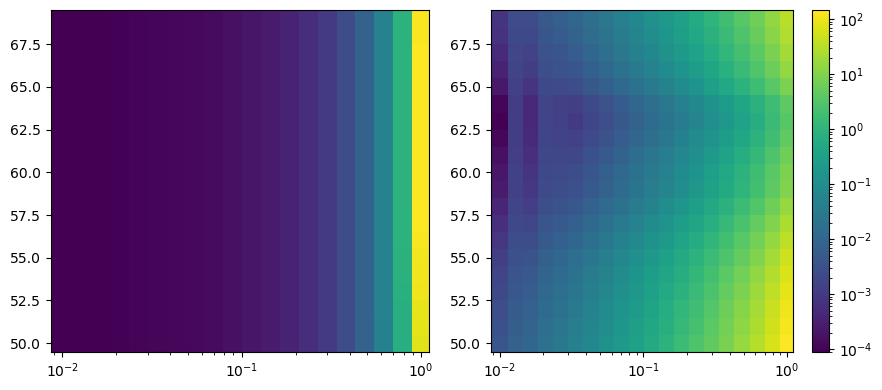

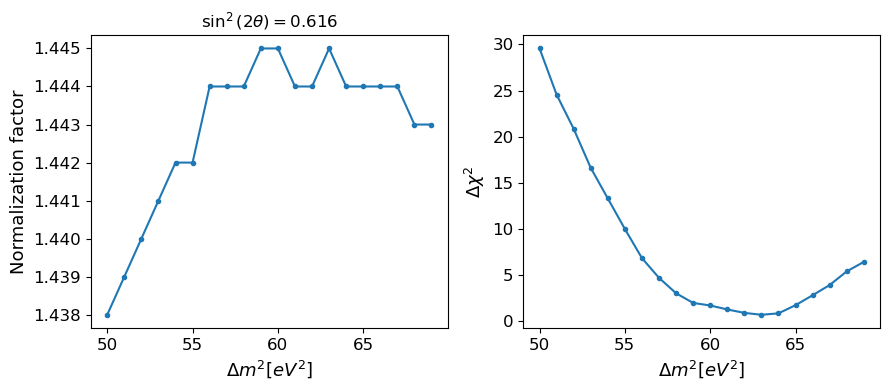

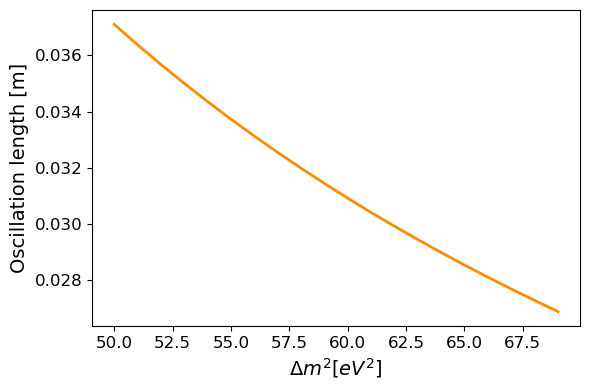

In [118]:
from matplotlib import colors
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
im0 = ax[0].pcolormesh(sin2_arr, dm2_arr, R)
im1 = ax[1].pcolormesh(sin2_arr, dm2_arr, dchi2, norm=colors.LogNorm(vmin=np.min(dchi2), vmax=np.max(dchi2)))

cb1 = plt.colorbar(im1, ax=ax[1])
ax[0].semilogx()
ax[1].semilogx()
plt.tight_layout()

id1 = 17
fig, ax2 = plt.subplots(1, 2, figsize=(9, 4))
ax2[0].plot(dm2_arr, R[:, id1], 'o-', ms=3,)
ax2[1].plot(dm2_arr, dchi2[:, id1], 'o-', ms=3, )
ax2[0].set_ylabel('Normalization factor', fontsize=13)
ax2[1].set_ylabel(r'$\Delta \chi^2$', fontsize=13)
for i in range(2):
    ax2[i].tick_params(labelsize=12)
    ax2[i].set_xlabel(r'$\Delta m^2 [eV^2]$', fontsize=13)
ax2[0].set_title(r'$\sin^2(2\theta)=$'+f'{sin2_arr[id1]:.3f}')
plt.tight_layout()

fig, ax3 = plt.subplots(figsize=(6, 4))
Losc = oscillation_length(dm2_arr, 0.75)
ax3.plot(dm2_arr, Losc, '-', lw=2, color='darkorange')
ax3.set_xlabel(r'$\Delta m^2 [eV^2]$', fontsize=14)
ax3.set_ylabel('Oscillation length [m]', fontsize=14)
ax3.tick_params(labelsize=12)
plt.tight_layout()

from oscillation import *
print(oscillation_length(60, 0.75))


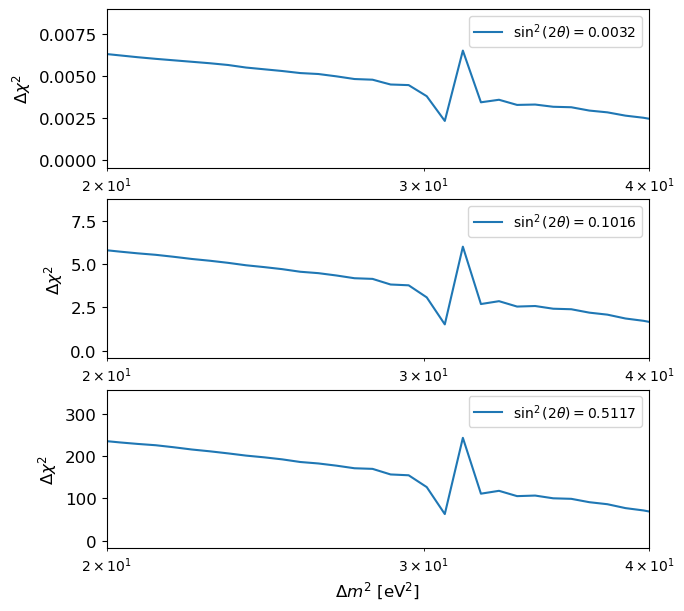

In [89]:
fig, ax = plt.subplots(3, 1, figsize=(7,7))
id1 = 50 # ID number for sin2_arr
ax[0].plot(dm2_shapeonlyscan, dchi2_shapeonlyscan[:, id1], '-', ms=3, label=r'$\sin^2(2\theta)=$'+f'{sin2_shapeonlyscan[id1]:.4f}')
id1 = 200 # ID number for sin2_arr
ax[1].plot(dm2_shapeonlyscan, dchi2_shapeonlyscan[:, id1], '-', ms=3, label=r'$\sin^2(2\theta)=$'+f'{sin2_shapeonlyscan[id1]:.4f}')
id1 = 270 # ID number for sin2_arr
ax[2].plot(dm2_shapeonlyscan, dchi2_shapeonlyscan[:, id1], '-', ms=3, label=r'$\sin^2(2\theta)=$'+f'{sin2_shapeonlyscan[id1]:.4f}')
for i in range(3):
    ax[i].semilogx()
    ax[i].legend(fontsize=10)
    ax[i].set_xlabel(r'$\Delta m^2$ [eV$^2$]', fontsize=12)
    ax[i].set_ylabel(r'$\Delta \chi^2$', fontsize=12)
    ax[i].tick_params(labelsize=12)
    ax[i].set_xlim(20, 40)

## Normalization fit with iminuit 

Instead of manual scanning of the normalization factor $R$, I also implemented a function to fit it by iminuit with LeastSquare method. Both dataset and fitting pdf are binned into histogram with the same binning strategy, with simple Poisson fluctuations as the errors for now, and a least square minimization method is adopted.

In [70]:
my_fit._set_data_dm2(0.0)
my_fit._set_data_sin2(0.0)
my_fit._set_fit_dm2(1.0)
my_fit._set_fit_sin2(0.1)

R, Rerr, m1,  = my_fit.calculate_shape_only_dchi2_asimov_fitRate(draw=False)

m1


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.55 (χ²/ndof = 0.1)       │              Nfcn = 13               │
│ EDM = 5.82e-06 (Goal: 0.0002)    │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R        │   1.058   │   0.014   │            │            │    0    │    2    │       │
│ 1 │ binwidth │  30.0e-3  │  0.3e-3   │            │            │         │         │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────┐
│          │        R binwidth │
├──────────┼───────────────────┤
│        R │ 0.000189        0 │
│ binwidth │        0        0 │
└──────────┴───────────────────┘

### Test unbinned fits
As I saw some structures in the 2D $\Delta \chi^2$ maps above, which appears on those mass splits matching the oscillation period length to the bin width, it's interested to explore if those structures happen with unbinned fitting as well. 

In [10]:
# nEXO exp
source_nEXO = neutrino_source('Cr51', 1e5, [0.75], [1.0])
det_nEXO = detector('nEXO')
det_nEXO.update_geometry(1.183, 1.133)
det_nEXO.position = (0, 0, 0)
dist = 0.1
source_nEXO.position = (0, 0, -det_nEXO.height/2-dist)
det_nEXO.run_time = 100 # days

dm2, sin2theta_square = 0.0, 0.0
gen1 = MC_generator(source_nEXO, det_nEXO, dm2=dm2, sin2theta_square=sin2theta_square, int_type='CC'); 

my_fit = fitter(source_nEXO, det_nEXO)

A Cr51 hot neutrino source with nominal 100000.0 in xx years with neutrino energies [0.75] and branch ratios [1.0] is created.


In [3]:
den, itg = gen1.expected_rate_and_integral(0.5, 0.0, 0.0)

TypeError: MC_generator.radius_integral() missing 2 required positional arguments: 'dm2' and 'sin2theta_square'

In [13]:
bl_step = 0.01
rmin = np.arange(gen1.baseline_min, gen1.baseline_max, bl_step)
rmax = rmin + bl_step

R_int = np.zeros(len(rmin))
R_den = np.zeros(len(rmin))
for i, (r1, r2) in enumerate( zip(rmin, rmax) ):
    R_den[i] = gen1.expected_rate_and_integral(r1, 0.0, 0.0)[0]
    R_int[i] = gen1.expected_rate_and_integral(r1, 0.0, 0.0)[1]


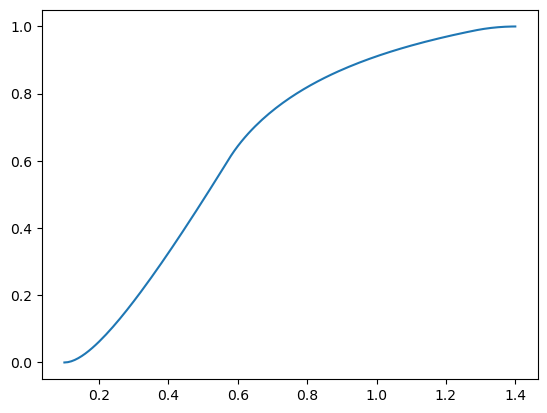

In [14]:
plt.plot(rmin, R_int)

## Test position-smeared PDF fitting
I generate smeared PDFs first and do fitting only in the fitter class.

/var/tmp/yu47/ipykernel_379203/471668038.py:39: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for i, collection in enumerate(CS.collections):


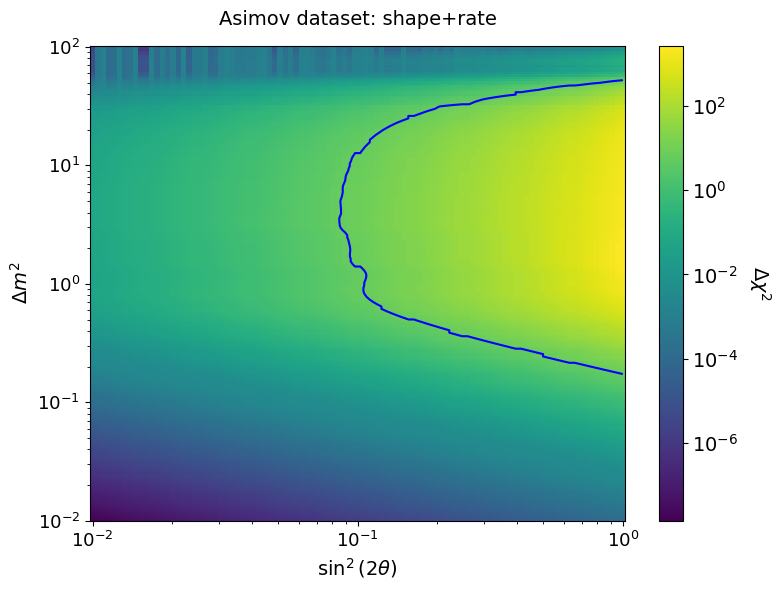

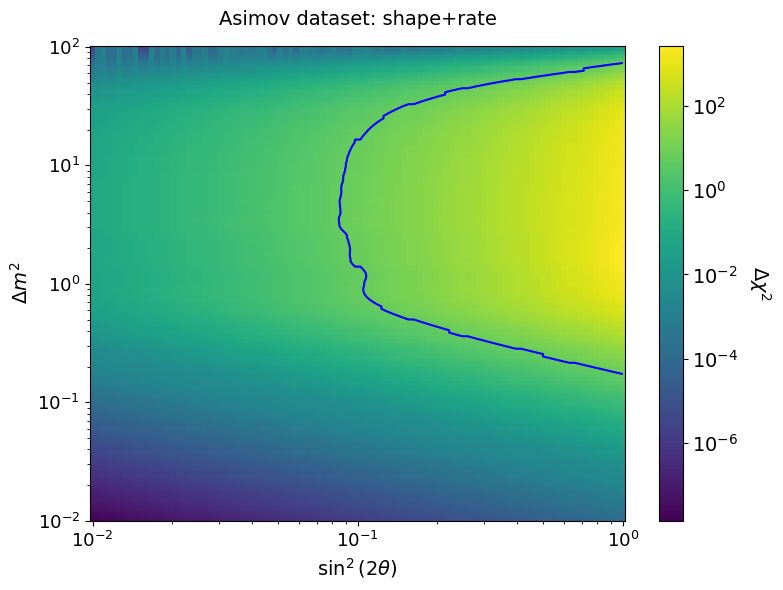

In [15]:
dm2 = np.logspace(-2, 2, 200)
sin2 = np.logspace(-2, 0, 100)

my_fit._set_data_dm2(0.0)
my_fit._set_data_sin2(0.0)


pdffilename = '/p/lustre1/yu47/Sterile_Neutrino/jobs/PDFs/Ev750_dist10cm_3cmbin/dm2From-2.00To2.00_sin2thetasquareFrom-2.00To0.00_Ev750keV_dist10cm_3.0cmbin_smear1.0cmResol_all.p'
my_fit._set_pdf_filename(pdffilename)
my_fit.load_pdfs()
my_fit._set_bin_width(0.03)
#my_fit.calculate_shape_only_dchi2_asimov_fixedRate(smear=True, preload=True)
my_fit.calculate_shape_only_dchi2_asimov_scanRate(smear=True, preload=True)
_, x_s3, y_s3,  = plot_2d(dm2, sin2, [], my_fit.pre_load_dchi2_all, plotR=False, method='shape+rate', contour=True, levels=[5.991] )



pdffilename = '/p/lustre1/yu47/Sterile_Neutrino/jobs/PDFs/Ev750_dist10cm_1cmbin/dm2From-2.00To2.00_sin2thetasquareFrom-2.00To0.00_Ev750keV_dist10cm_1.0cmbin_smear1.0cmResol_all.p'
my_fit._set_pdf_filename(pdffilename)
my_fit.load_pdfs()
my_fit._set_bin_width(0.01)
#my_fit.calculate_shape_only_dchi2_asimov_fixedRate(smear=True, preload=True)
my_fit.calculate_shape_only_dchi2_asimov_scanRate(smear=True, preload=True)
_, x_s1, y_s1,  = plot_2d(dm2, sin2, [], my_fit.pre_load_dchi2_all, plotR=False, method='shape+rate', contour=True, levels=[5.991] )


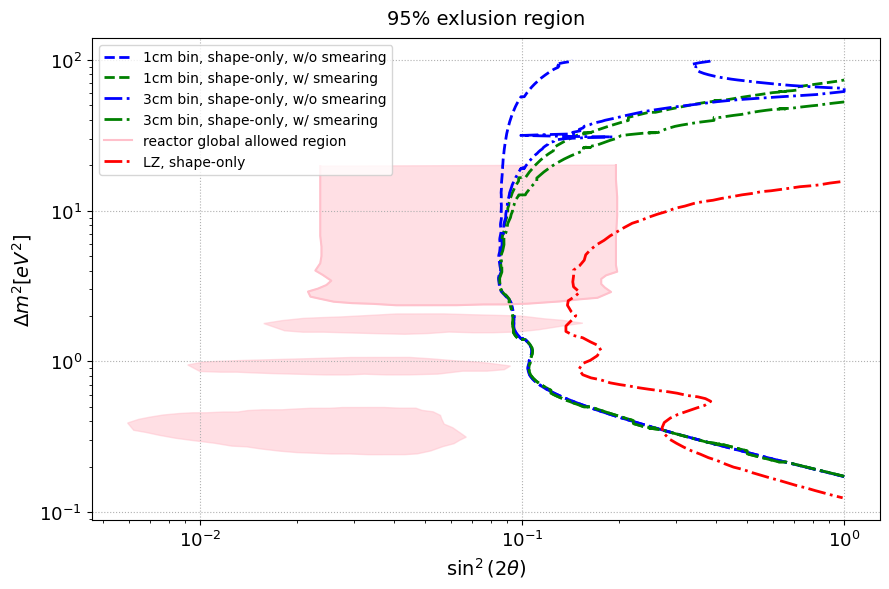

In [18]:
my_fit.other_exp_files = ['/p/lustre1/yu47/Sterile_Neutrino/sensitivity/data/LZ_natural_LXe_shapeonly.csv']
my_fit.load_other_experiments_sensitivity()

fig, ax = plt.subplots(figsize=(9, 6))


ax.plot(x2_1[0], y2_1[0], '--', color='blue',   linewidth=2, label='1cm bin, shape-only, w/o smearing')
ax.plot(x_s1[0], y_s1[0], '--', color='green',  linewidth=2, label='1cm bin, shape-only, w/ smearing')

ax.plot(x2_3[0], y2_3[0], '-.', color='blue',   linewidth=2, label='3cm bin, shape-only, w/o smearing')
ax.plot(x_s3[0], y_s3[0], '-.', color='green',  linewidth=2, label='3cm bin, shape-only, w/ smearing')

for k, (xs, ys) in enumerate( zip(reactor_x, reactor_y) ):
    if k == 0:
        ax.plot(xs, ys, '-', color='pink', label='reactor global allowed region')
    ax.fill(xs, ys, '-', color='pink', alpha=0.5)


ax.plot(my_fit.other_exp_sens[0][:, 0], my_fit.other_exp_sens[0][:, 1], lw=2, linestyle='-.', color='red', label='LZ, shape-only')
ax.loglog()
ax.set_xlabel(r'$\sin^2(2\theta)$', fontsize=14)
ax.set_ylabel(r"$\Delta m^2 [eV^2]$", fontsize=14)
ax.tick_params(labelsize=13)
#ax.legend(fontsize=12, loc=(0.52, 0.35))
ax.legend(fontsize=10)
ax.grid(linestyle=':')
ax.set_title('95% exlusion region', fontsize=14, pad=10)
plt.tight_layout()  
#ax.set_ylim(1e-1, 1e1)
#plt.savefig('../plots/AsimovComparison_binwidth1cm3cm5m.pdf')